In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
tsmc = yf.Ticker('2330.TW')
df = tsmc.history(start='2000-01-01', end='2024-03-19')

df['sma'] = df["Close"].rolling(20).mean()
df['std'] = df["Close"].rolling(20).std()
df['upper_band'] = df['sma'] + 1 * df['std']
df['lower_band'] = df['sma'] - 1 * df['std']
df.drop(['Dividends', 'Volume'], axis=1, inplace=True, errors='ignore')
df.tail(5)

,Open,High,Low,Close,Stock Splits,sma,std,upper_band,lower_band
Date,,,,,,,,,
2024-03-12 00:00:00+08:00,753.481385,767.416311,750.495329,766.420959,0.0,703.763565,39.829105,743.592670,663.934460
2024-03-13 00:00:00+08:00,781.351262,781.351262,773.388447,775.379150,0.0,710.930099,39.134953,750.065052,671.795147
2024-03-14 00:00:00+08:00,775.379136,781.351248,766.420969,780.355896,0.0,717.798029,38.635309,756.433338,679.162719
2024-03-15 00:00:00+08:00,767.416335,773.388446,749.500000,749.500000,0.0,720.585016,38.820037,759.405053,681.764979
2024-03-18 00:00:00+08:00,754.000000,765.000000,754.000000,764.000000,0.0,724.793747,38.731297,763.525044,686.062450


In [3]:
fund = 10000  # 初始資金

position = None

Buy_and_Hold = []
Sell_and_Short = []

Buy_Stock = []
Sell_Stock = []

profit_list = [0]

executesize = 0
total_revenue = 0
cumulative_profit = []
cumulative_profit_dates = []  # 日期列表

# 初始化一個空的list來存儲交易記錄
trading_records = []

for i in range(len(df)):
    if i == len(df) - 1:
        break

    if position is None:
        profit_list.append(0)

        if df['Close'].iloc[i] < df['lower_band'].iloc[i]:
            executesize = fund // df["High"].iloc[i+1]
            position = 'Buy_and_Hold'
            Buy_Stock.append(i+1)
            Buy_and_Hold.append(i+1)
            continue

        if df['Close'].iloc[i] > df['upper_band'].iloc[i]:
            executesize = fund // df["High"].iloc[i+1]
            position = 'Sell_and_Short'
            Sell_Stock.append(i+1)
            Sell_and_Short.append(i+1)
            continue

    elif position == 'Buy_and_Hold':
        profit = executesize * (df['Close'].iloc[i+1] - df['Close'].iloc[i])
        total_revenue = total_revenue + profit

        if fund + profit > 0:  # 檢查資金是否會變動
            fund += profit

            # 將交易記錄添加到list中
            trading_records.append({'日期': df.index[i],
                                    'Profit': fund,
                                    '策略損益(金額)': profit})
        else:
            position = None

        if df['Close'].iloc[i] > df['sma'].iloc[i] or i == len(df) - 2:
            profit = executesize * (df['Close'].iloc[i+1] - df['Close'].iloc[i])
            total_revenue = total_revenue + profit

            if fund + profit > 0:  # 檢查資金是否會變動
                fund = fund + profit

                # 將交易記錄添加到list中
                trading_records.append({'日期': df.index[i+1],
                                        'Profit': fund,
                                        '策略損益(金額)': profit})

            Sell_Stock.append(i)
            position = None

    elif position == 'Sell_and_Short':
        profit = executesize * (df['Close'].iloc[i] - df['Close'].iloc[i+1])
        total_revenue = total_revenue + profit

        if fund + profit > 0:  # 檢查資金是否會變動
            fund = fund + profit

            # 將交易記錄添加到list中
            trading_records.append({'日期': df.index[i],
                                    'Profit': fund,
                                    '策略損益(金額)': profit})
        else:
            position = None

        if df['Close'].iloc[i] < df['sma'].iloc[i] or i == len(df) - 2:
            profit = executesize * (df['Close'].iloc[i] - df['Close'].iloc[i+1])
            total_revenue = total_revenue + profit

            if fund + profit > 0:  # 檢查資金是否會變動
                fund = fund + profit

                # 將交易記錄添加到list中
                trading_records.append({'日期': df.index[i+1],
                                        'Profit': fund,
                                        '策略損益(金額)': profit})

            Buy_Stock.append(i)
            position = None

    if i in Buy_Stock or i in Sell_Stock:  # 檢查日期是否存在於交易點
        cumulative_profit_dates.append(df.index[i])  # 添加日期到列表中
        cumulative_profit.append(total_revenue)

# 如果有交易記錄，則將交易記錄保存為DataFrame並保存為CSV文件
if trading_records:
    # 將交易記錄保存為DataFrame
    trading_df = pd.DataFrame(trading_records)

    # 將DataFrame保存為CSV文件
    trading_df.to_csv('trading_records.csv', index=False,encoding='utf-8-sig')


In [4]:
print("Total Profit/Loss:", total_revenue)
print("Buy Points:", Buy_Stock)
print("Sell Points:", Sell_Stock)
print("Buy and Hold Points:", Buy_and_Hold)
print("Sell and Short Points:", Sell_and_Short)

Total Profit/Loss: 3359.600959777832
Buy Points: [34, 36, 49, 71, 73, 93, 101, 116, 122, 134, 143, 173, 177, 227, 229, 249, 284, 287, 299, 325, 355, 357, 368, 377, 382, 395, 404, 424, 427, 443, 513, 531, 541, 544, 587, 590, 605, 631, 657, 661, 663, 695, 747, 767, 770, 802, 808, 843, 864, 906, 917, 925, 938, 940, 969, 973, 985, 992, 1005, 1013, 1025, 1062, 1065, 1091, 1094, 1119, 1127, 1129, 1151, 1153, 1158, 1174, 1183, 1218, 1222, 1234, 1244, 1278, 1282, 1306, 1308, 1320, 1342, 1347, 1349, 1377, 1380, 1431, 1439, 1450, 1452, 1460, 1479, 1492, 1494, 1506, 1510, 1557, 1564, 1576, 1578, 1591, 1604, 1609, 1641, 1647, 1649, 1690, 1694, 1724, 1731, 1734, 1751, 1765, 1775, 1798, 1816, 1819, 1830, 1842, 1847, 1867, 1877, 1887, 1895, 1916, 1918, 1940, 1943, 1946, 1971, 1984, 1999, 2006, 2014, 2024, 2044, 2047, 2060, 2097, 2100, 2103, 2111, 2129, 2132, 2148, 2150, 2161, 2175, 2197, 2219, 2221, 2244, 2273, 2311, 2313, 2342, 2367, 2373, 2375, 2378, 2407, 2413, 2459, 2485, 2492, 2496, 2501, 2510, 

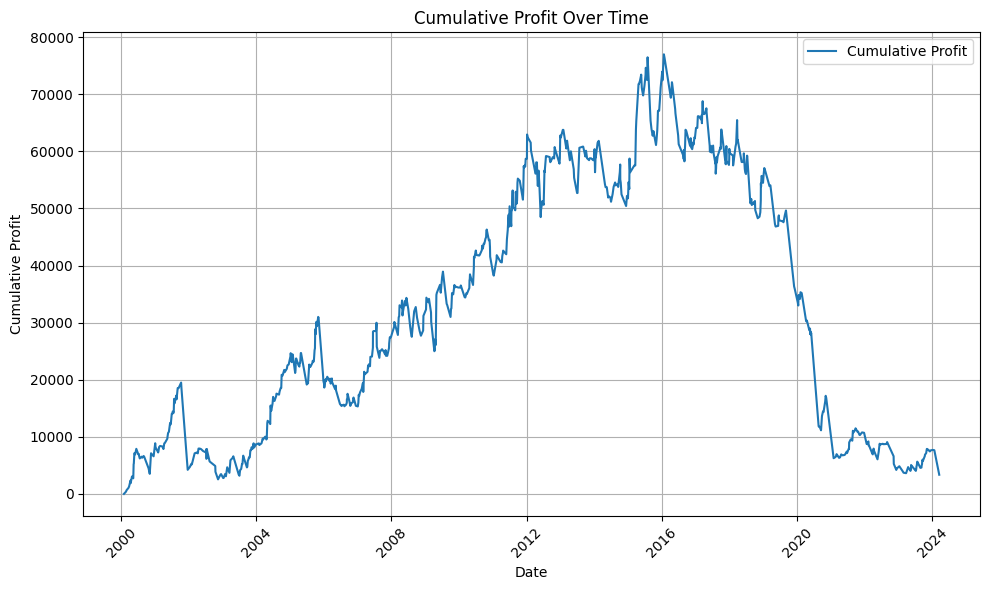

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(cumulative_profit_dates, cumulative_profit, label='Cumulative Profit')
plt.xlabel('Date')
plt.ylabel('Cumulative Profit')
plt.title('Cumulative Profit Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()